# Randomized SVD Image Compression Playground

This notebook lets you compare deterministic truncated SVD and randomized SVD (rSVD) on any grayscale image.
It measures reconstruction error (Frobenius norm relative to the original) and timing for different rSVD parameters so you can see the accuracy-speed trade-off.


**Workflow**

1. Run the import/setup cells.
2. Provide a path to an image file (PNG/JPG/etc.) when prompted, or press enter to use a synthetic demo image.
3. Adjust the rank, oversampling, and power iteration parameters to explore rSVD behavior.
4. Run the experiment, examine the metrics table/plots, and inspect the reconstructed images.


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from time import perf_counter

plt.rcParams.update({
    "figure.figsize": (6, 4),
    "image.cmap": "gray",
    "font.size": 12,
})
np.set_printoptions(precision=3, suppress=True)


In [106]:
save_figures = True
figure_output_dir = Path("figures")
if save_figures:
    figure_output_dir.mkdir(parents=True, exist_ok=True)

def sanitize_filename(text, default="figure"):
    if not text:
        return default
    sanitized = "".join(c if c.isalnum() or c in ("-", "_") else "_" for c in str(text))
    sanitized = sanitized.strip("_")[:120]
    return sanitized or default


def save_named_figure(fig, label):
    if not save_figures:
        return
    filename = f"{sanitize_filename(label)}.png"
    path = figure_output_dir / filename
    fig.savefig(path, bbox_inches="tight", dpi=240)
    print(f"Saved figure -> {path}")


In [107]:
def load_grayscale_image(path):
    """Load an image file, convert it to grayscale, and return a float64 array scaled to [0, 1]."""
    path = Path(path).expanduser()
    if not path.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    image = Image.open(path).convert("L")
    return np.asarray(image, dtype=np.float64) / 255.0


def create_demo_image(size=256):
    """Generate a synthetic gradient + stripe image as a fallback demo."""
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    grid = np.outer(y, x)
    stripes = 0.25 * np.sin(18 * np.pi * x)
    vignette = np.clip(1.5 * grid * (1 - grid), 0, 1)
    demo = 0.55 * grid + 0.35 * vignette
    demo += 0.1 * np.outer(np.ones_like(y), stripes)
    return np.clip(demo, 0, 1)


def describe_image(matrix):
    matrix = np.asarray(matrix)
    print(f"Shape: {matrix.shape}, min={matrix.min():.3f}, max={matrix.max():.3f}")


In [108]:
def truncated_svd(matrix, rank):
    """Return the best rank-k approximation via deterministic SVD."""
    matrix = np.asarray(matrix, dtype=np.float64)
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    k = min(rank, len(S))
    return U[:, :k], S[:k], Vt[:k, :]


def randomized_svd(matrix, rank, oversampling=5, n_iter=2, random_state=None):
    """Compute an rSVD approximation using a Gaussian projection and optional power iterations."""
    matrix = np.asarray(matrix, dtype=np.float64)
    m, n = matrix.shape
    k = min(rank, m, n)
    l = min(k + oversampling, n)
    rng = np.random.default_rng(random_state)
    projector = rng.standard_normal(size=(n, l))
    sample = matrix @ projector
    for _ in range(max(n_iter, 0)):
        sample = matrix @ (matrix.T @ sample)
    Q, _ = np.linalg.qr(sample, mode="reduced")
    B = Q.T @ matrix
    Uh, S, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ Uh
    return U[:, :k], S[:k], Vt[:k, :]


def reconstruct_image(U, S, Vt):
    """Reconstruct an image matrix from SVD factors."""
    return (U * S) @ Vt


def relative_frobenius_error(original, approximation):
    """Compute ||A - A_hat||_F / ||A||_F as an error bound surrogate."""
    original = np.asarray(original, dtype=np.float64)
    approximation = np.asarray(approximation, dtype=np.float64)
    denom = np.linalg.norm(original, ord="fro")
    if denom == 0:
        return 0.0
    return np.linalg.norm(original - approximation, ord="fro") / denom


def timed_call(fn, *args, **kwargs):
    start = perf_counter()
    output = fn(*args, **kwargs)
    end = perf_counter()
    return output, end - start


In [109]:
image_path = input("Enter path to an image (leave blank for synthetic demo): ").strip()
if image_path:
    image_matrix = load_grayscale_image(image_path)
    source_description = f"Loaded from {Path(image_path).expanduser()}"
else:
    image_matrix = create_demo_image()
    source_description = "Synthetic gradient demo image (provide a path above to use your own data)."

print(source_description)
describe_image(image_matrix)


Loaded from /Users/imran.turganov/code/projects/rSVD/ronaldo.jpg
Shape: (2000, 3000), min=0.000, max=1.000


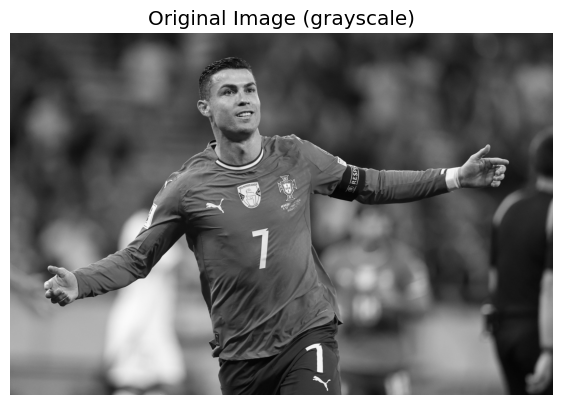

Saved figure -> figures/original_image.png


In [110]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image_matrix, vmin=0, vmax=1)
ax.set_title("Original Image (grayscale)")
ax.axis("off")
plt.show()
save_named_figure(fig, "original_image")


In [111]:
ranks_to_try = [10, 30, 60, 120]
power_iterations = [0, 1, 2, 3, 4]
oversampling = 10
random_state = 7

print("Ranks:", ranks_to_try)
print("Power iterations:", power_iterations)
print("Oversampling:", oversampling)
print("Random seed:", random_state)


Ranks: [10, 30, 60, 120]
Power iterations: [0, 1, 2, 3, 4]
Oversampling: 10
Random seed: 7


In [112]:
results = []
approximations = {}

for requested_rank in ranks_to_try:
    (svd_factors, svd_time) = timed_call(truncated_svd, image_matrix, requested_rank)
    U, S, Vt = svd_factors
    eff_rank = len(S)
    svd_approx = reconstruct_image(U, S, Vt)
    svd_error = relative_frobenius_error(image_matrix, svd_approx)
    key = ("SVD", eff_rank, 0)
    approximations[key] = svd_approx
    results.append({
        "method": "SVD",
        "requested_rank": requested_rank,
        "rank": eff_rank,
        "power_iterations": 0,
        "oversampling": 0,
        "relative_error": svd_error,
        "runtime_s": svd_time,
        "key": key,
    })

    for n_iter in power_iterations:
        (rsvd_factors, rsvd_time) = timed_call(
            randomized_svd,
            image_matrix,
            requested_rank,
            oversampling=oversampling,
            n_iter=n_iter,
            random_state=random_state,
        )
        Ur, Sr, Vtr = rsvd_factors
        eff_rank_rsvd = len(Sr)
        approx = reconstruct_image(Ur, Sr, Vtr)
        error = relative_frobenius_error(image_matrix, approx)
        key = ("rSVD", eff_rank_rsvd, n_iter)
        approximations[key] = approx
        results.append({
            "method": "rSVD",
            "requested_rank": requested_rank,
            "rank": eff_rank_rsvd,
            "power_iterations": n_iter,
            "oversampling": oversampling,
            "relative_error": error,
            "runtime_s": rsvd_time,
            "key": key,
        })

metrics_df = pd.DataFrame(results)
metrics_df["runtime_ms"] = metrics_df["runtime_s"] * 1000
metrics_df.sort_values(["method", "rank", "power_iterations"], inplace=True)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df


,method,requested_rank,rank,power_iterations,oversampling,relative_error,runtime_s,key,runtime_ms
0,SVD,10,10,0,0,0.176009,3.533560,"(SVD, 10, 0)",3533.559708
1,SVD,30,30,0,0,0.106135,2.884754,"(SVD, 30, 0)",2884.754208
2,SVD,60,60,0,0,0.074829,2.406778,"(SVD, 60, 0)",2406.778166
3,SVD,120,120,0,0,0.050005,2.409988,"(SVD, 120, 0)",2409.987625
4,rSVD,10,10,0,10,0.213035,0.009417,"(rSVD, 10, 0)",9.416625
5,rSVD,10,10,1,10,0.176357,0.013883,"(rSVD, 10, 1)",13.882625
6,rSVD,10,10,2,10,0.176022,0.013159,"(rSVD, 10, 2)",13.158958
7,rSVD,10,10,3,10,0.176010,0.016446,"(rSVD, 10, 3)",16.446167
8,rSVD,10,10,4,10,0.176009,0.020689,"(rSVD, 10, 4)",20.689417
9,rSVD,30,30,0,10,0.148484,0.020162,"(rSVD, 30, 0)",20.162125


In [113]:
latex_float = lambda x: f"{x:.4f}"

svd_table = (
    metrics_df[metrics_df["method"] == "SVD"]
    [["rank", "relative_error", "runtime_ms"]]
    .rename(columns={
        "rank": "Rank",
        "relative_error": "Relative Error",
        "runtime_ms": "Runtime [ms]",
    })
)
print("SVD metrics (LaTeX):")
print(
    svd_table.to_latex(
        index=False,
        float_format=latex_float,
        caption="Deterministic truncated SVD statistics",
        label="tab:svd_metrics",
    )
)

rsvd_table = (
    metrics_df[metrics_df["method"] == "rSVD"]
    [["rank", "power_iterations", "oversampling", "relative_error", "runtime_ms"]]
    .rename(columns={
        "rank": "Rank",
        "power_iterations": "q",
        "oversampling": "Oversampling",
        "relative_error": "Relative Error",
        "runtime_ms": "Runtime [ms]",
    })
    .sort_values(["Rank", "q"])
)
print("rSVD metrics (LaTeX):")
print(
    rsvd_table.to_latex(
        index=False,
        float_format=latex_float,
        caption="Randomized SVD statistics across ranks and power iterations",
        label="tab:rsvd_metrics",
    )
)

best_rsvd = (
    metrics_df[metrics_df["method"] == "rSVD"]
    .sort_values("relative_error")
    .groupby("rank", as_index=False)
    .first()
)
svd_comp = svd_table.rename(columns={"Relative Error": "SVD Error", "Runtime [ms]": "SVD Runtime [ms]"})
rsvd_comp = best_rsvd.rename(
    columns={
        "rank": "Rank",
        "power_iterations": "Best q",
        "relative_error": "Best rSVD Error",
        "runtime_ms": "Best rSVD Runtime [ms]",
    }
)[["Rank", "Best q", "Best rSVD Error", "Best rSVD Runtime [ms]"]]
comparison = rsvd_comp.merge(svd_comp, on="Rank", how="left")
comparison["Error Gain"] = comparison["SVD Error"] - comparison["Best rSVD Error"]
comparison["Runtime Ratio (SVD/rSVD)"] = comparison["SVD Runtime [ms]"] / comparison[
    "Best rSVD Runtime [ms]"
]
comparison = comparison[
    [
        "Rank",
        "Best q",
        "Best rSVD Error",
        "SVD Error",
        "Error Gain",
        "Best rSVD Runtime [ms]",
        "SVD Runtime [ms]",
        "Runtime Ratio (SVD/rSVD)",
    ]
]
print("Best rSVD vs SVD comparison (LaTeX):")
print(
    comparison.to_latex(
        index=False,
        float_format=latex_float,
        caption="Best-performing randomized SVD settings per rank versus deterministic SVD",
        label="tab:svd_rsvd_comparison",
    )
)


SVD metrics (LaTeX):
\begin{table}
\caption{Deterministic truncated SVD statistics}
\label{tab:svd_metrics}
\begin{tabular}{rrr}
\toprule
Rank & Relative Error & Runtime [ms] \\
\midrule
10 & 0.1760 & 3533.5597 \\
30 & 0.1061 & 2884.7542 \\
60 & 0.0748 & 2406.7782 \\
120 & 0.0500 & 2409.9876 \\
\bottomrule
\end{tabular}
\end{table}

rSVD metrics (LaTeX):
\begin{table}
\caption{Randomized SVD statistics across ranks and power iterations}
\label{tab:rsvd_metrics}
\begin{tabular}{rrrrr}
\toprule
Rank & q & Oversampling & Relative Error & Runtime [ms] \\
\midrule
10 & 0 & 10 & 0.2130 & 9.4166 \\
10 & 1 & 10 & 0.1764 & 13.8826 \\
10 & 2 & 10 & 0.1760 & 13.1590 \\
10 & 3 & 10 & 0.1760 & 16.4462 \\
10 & 4 & 10 & 0.1760 & 20.6894 \\
30 & 0 & 10 & 0.1485 & 20.1621 \\
30 & 1 & 10 & 0.1081 & 20.4272 \\
30 & 2 & 10 & 0.1064 & 22.6097 \\
30 & 3 & 10 & 0.1062 & 39.1003 \\
30 & 4 & 10 & 0.1062 & 41.4084 \\
60 & 0 & 10 & 0.1093 & 27.2419 \\
60 & 1 & 10 & 0.0772 & 36.8700 \\
60 & 2 & 10 & 0.0754 & 46.8

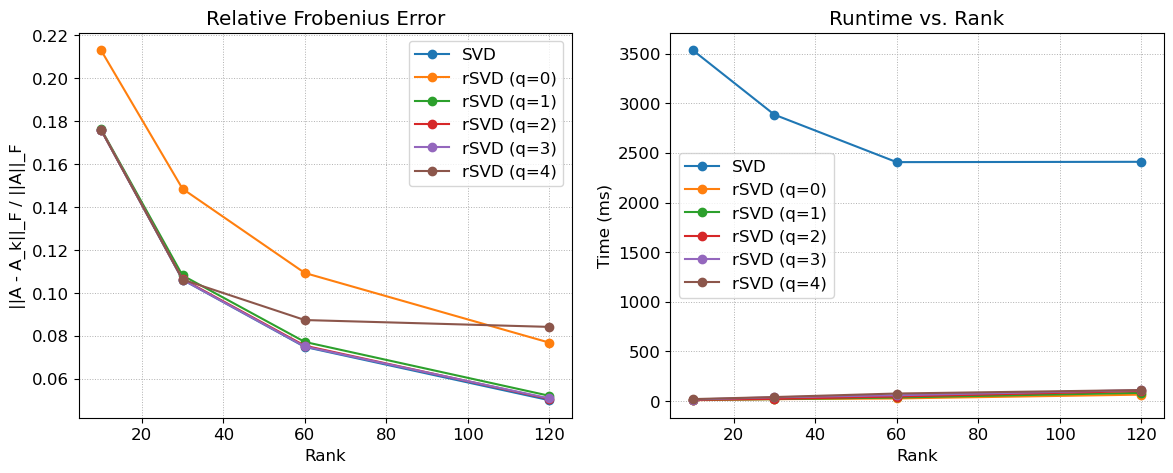

Saved figure -> figures/metrics_curves.png


In [114]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
error_ax, runtime_ax = axes

svd_data = metrics_df[metrics_df["method"] == "SVD"]
if not svd_data.empty:
    error_ax.plot(svd_data["rank"], svd_data["relative_error"], marker="o", label="SVD")
    runtime_ax.plot(svd_data["rank"], svd_data["runtime_ms"], marker="o", label="SVD")

for n_iter, subset in metrics_df[metrics_df["method"] == "rSVD"].groupby("power_iterations"):
    label = f"rSVD (q={n_iter})"
    error_ax.plot(subset["rank"], subset["relative_error"], marker="o", label=label)
    runtime_ax.plot(subset["rank"], subset["runtime_ms"], marker="o", label=label)

error_ax.set_title("Relative Frobenius Error")
error_ax.set_xlabel("Rank")
error_ax.set_ylabel("||A - A_k||_F / ||A||_F")
error_ax.legend()
error_ax.grid(True, linestyle=":", linewidth=0.7)

runtime_ax.set_title("Runtime vs. Rank")
runtime_ax.set_xlabel("Rank")
runtime_ax.set_ylabel("Time (ms)")
runtime_ax.legend()
runtime_ax.grid(True, linestyle=":", linewidth=0.7)

plt.show()
save_named_figure(fig, "metrics_curves")


Saved figure -> figures/comparison_Original_image.png


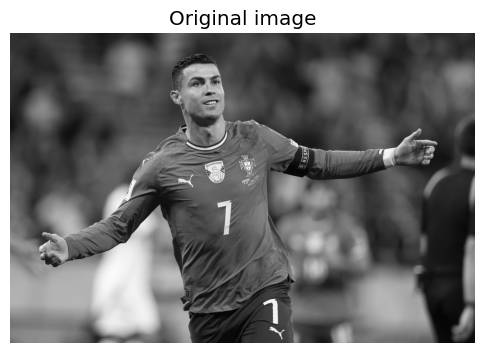

Saved figure -> figures/comparison_SVD_rank_120_runtime_2410_0_ms.png


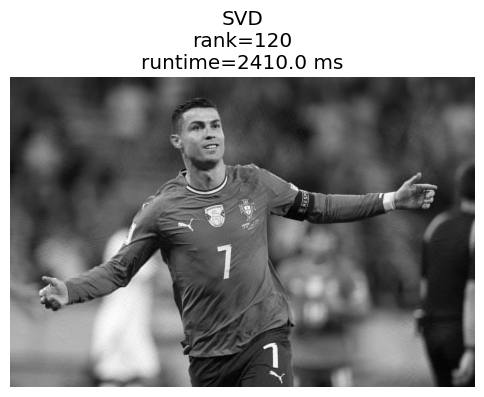

Saved figure -> figures/comparison_rSVD__q_2__rank_120_err_5_057e-02_runtime_101_8_ms.png


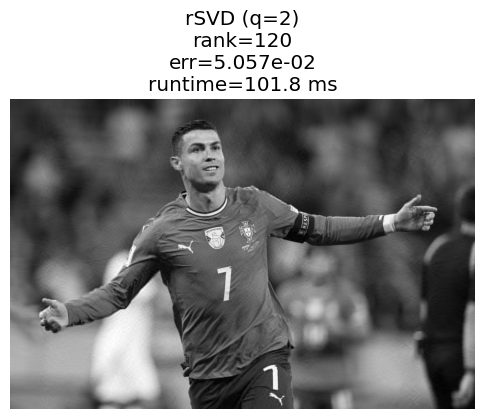

Saved figure -> figures/comparison_rSVD__q_3__rank_120_err_5_084e-02_runtime_111_1_ms.png


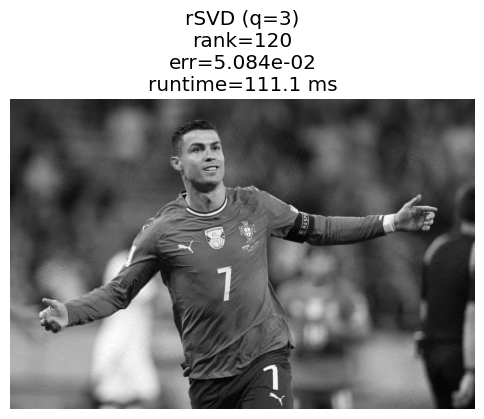

In [115]:
preview_rows = []
if not metrics_df.empty:
    svd_rows = metrics_df[metrics_df["method"] == "SVD"]
    if not svd_rows.empty:
        preview_rows.append(svd_rows.iloc[0])
        preview_rows.append(svd_rows.iloc[-1])
    rsvd_rows = metrics_df[metrics_df["method"] == "rSVD"].nsmallest(2, "relative_error")
    preview_rows.extend(list(rsvd_rows.itertuples(index=False)))

if preview_rows:
    def row_value(row, field):
        if hasattr(row, "_fields"):
            return getattr(row, field)
        return row[field]

    unique_keys = []
    filtered_rows = []
    for row in preview_rows:
        rank_value = row_value(row, "rank")
        method_value = row_value(row, "method")
        if method_value == "SVD" and rank_value == 10:
            continue
        key = tuple(row_value(row, "key"))
        if key in unique_keys:
            continue
        unique_keys.append(key)
        filtered_rows.append(row)

    image_entries = [("Original image", image_matrix)]
    for row in filtered_rows:
        key = tuple(row_value(row, "key"))
        approx = approximations.get(key)
        if approx is None:
            continue
        runtime_ms = row_value(row, "runtime_ms")
        runtime_text = f"runtime={runtime_ms:.1f} ms" if runtime_ms is not None else "runtime=?"
        method_value = row_value(row, "method")
        if method_value == "SVD":
            title = f"SVD\nrank={row_value(row, 'rank')}\n{runtime_text}"
        else:
            title = (
                f"rSVD (q={row_value(row, 'power_iterations')})\n"
                f"rank={row_value(row, 'rank')}\n"
                f"err={row_value(row, 'relative_error'):.3e}\n{runtime_text}"
            )
        image_entries.append((title, approx))

    for title, data in image_entries:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(data, vmin=0, vmax=1)
        ax.set_title(title)
        ax.axis("off")
        label = f"comparison_{sanitize_filename(title)}"
        save_named_figure(fig, label)
        plt.show()
else:
    print("Run the experiment cell above first to populate results.")


Saved figure -> figures/rank60_SVD_rank_60_err_7_483e-02_runtime_2406_8_ms.png


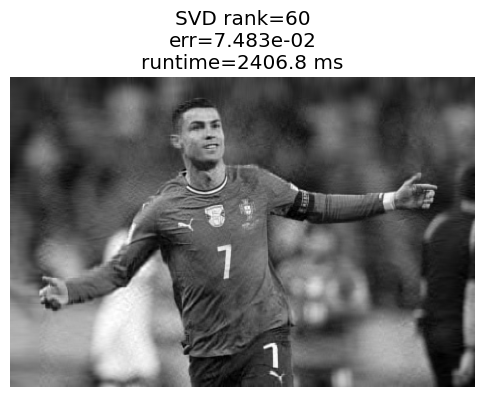

Saved figure -> figures/rank60_rSVD_q_1_rank_60_err_7_715e-02_runtime_36_9_ms.png


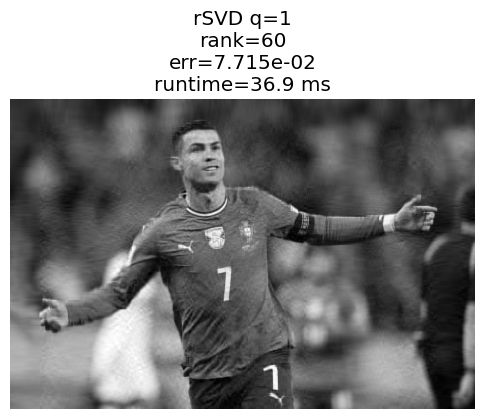

Saved figure -> figures/rank60_rSVD_q_2_rank_60_err_7_540e-02_runtime_46_8_ms.png


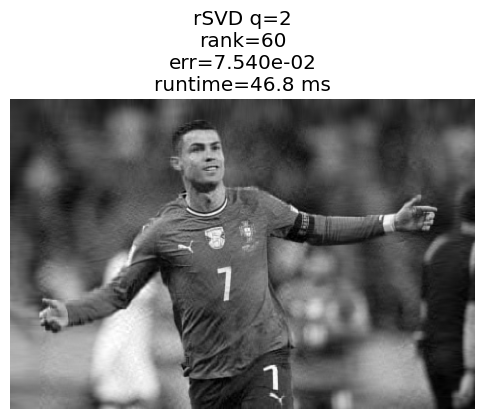

Saved figure -> figures/rank60_rSVD_q_3_rank_60_err_7_504e-02_runtime_59_3_ms.png


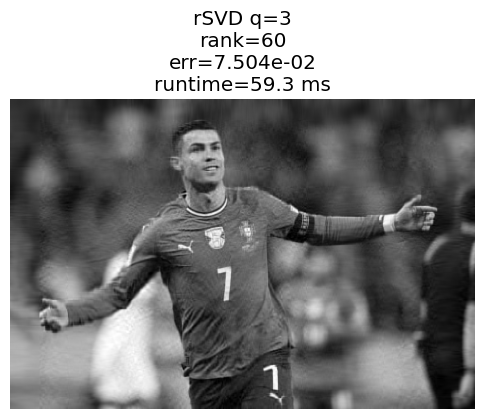

Saved figure -> figures/rank60_rSVD_q_4_rank_60_err_8_735e-02_runtime_76_9_ms.png


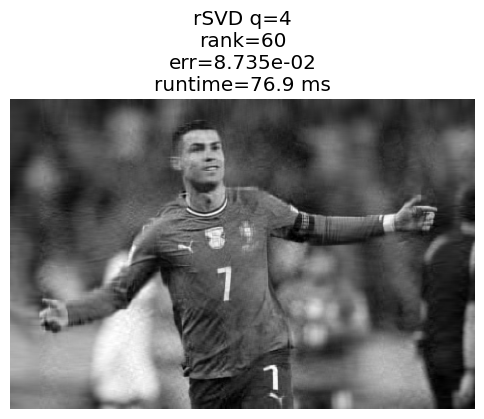

In [116]:
rank_to_focus = 60
rsvd_powers = [1, 2, 3, 4]

entries = []

def pick_first_row(df, **filters):
    subset = df
    for key, value in filters.items():
        subset = subset[subset[key] == value]
    if subset.empty:
        return None
    return subset.iloc[0]

svd_row = pick_first_row(metrics_df, method="SVD", rank=rank_to_focus)
if svd_row is not None:
    entries.append((
        f"SVD rank={rank_to_focus}\n"
        f"err={svd_row.relative_error:.3e}\n"
        f"runtime={svd_row.runtime_ms:.1f} ms",
        tuple(svd_row.key),
    ))
else:
    print(f"No SVD result found for rank={rank_to_focus}.")

for power in rsvd_powers:
    rsvd_row = pick_first_row(
        metrics_df,
        method="rSVD",
        rank=rank_to_focus,
        power_iterations=power,
    )
    if rsvd_row is None:
        print(f"No rSVD result for rank={rank_to_focus}, q={power}.")
        continue
    entries.append((
        f"rSVD q={power}\n"
        f"rank={rank_to_focus}\n"
        f"err={rsvd_row.relative_error:.3e}\n"
        f"runtime={rsvd_row.runtime_ms:.1f} ms",
        tuple(rsvd_row.key),
    ))

if entries:
    for title, key in entries:
        approx = approximations.get(key)
        if approx is None:
            print(f"Approximation missing for key={key}.")
            continue
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(approx, vmin=0, vmax=1)
        ax.set_title(title)
        ax.axis("off")
        label = f"rank{rank_to_focus}_" + sanitize_filename(title)
        save_named_figure(fig, label)
        plt.show()
else:
    print("No matching entries found; adjust rank_to_focus or rerun the experiment cell.")


### Notes

- The relative Frobenius error shown above acts as an error bound surrogate: smaller values mean the approximation is closer to the original.
- Increasing the target rank always improves the best possible approximation (SVD), while rSVD trades a small amount of accuracy for speed.
- Oversampling and power iterations shrink the randomized projection error at the cost of extra passes over the matrix. Use them when you need more accuracy without jumping to a much larger rank.
- To explore color images, run the notebook channel per color component (e.g., process RGB channels separately) or convert the image to another colorspace before compression.
